In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train_preds = pd.read_csv("../preds/train_preds_vanillaAE.csv", parse_dates=["date"])
preds = pd.read_csv("../preds/preds_vanillaAE.csv", parse_dates=["date"])
preds["set"] = preds.ts_id.str.split("_", expand=True)[1]

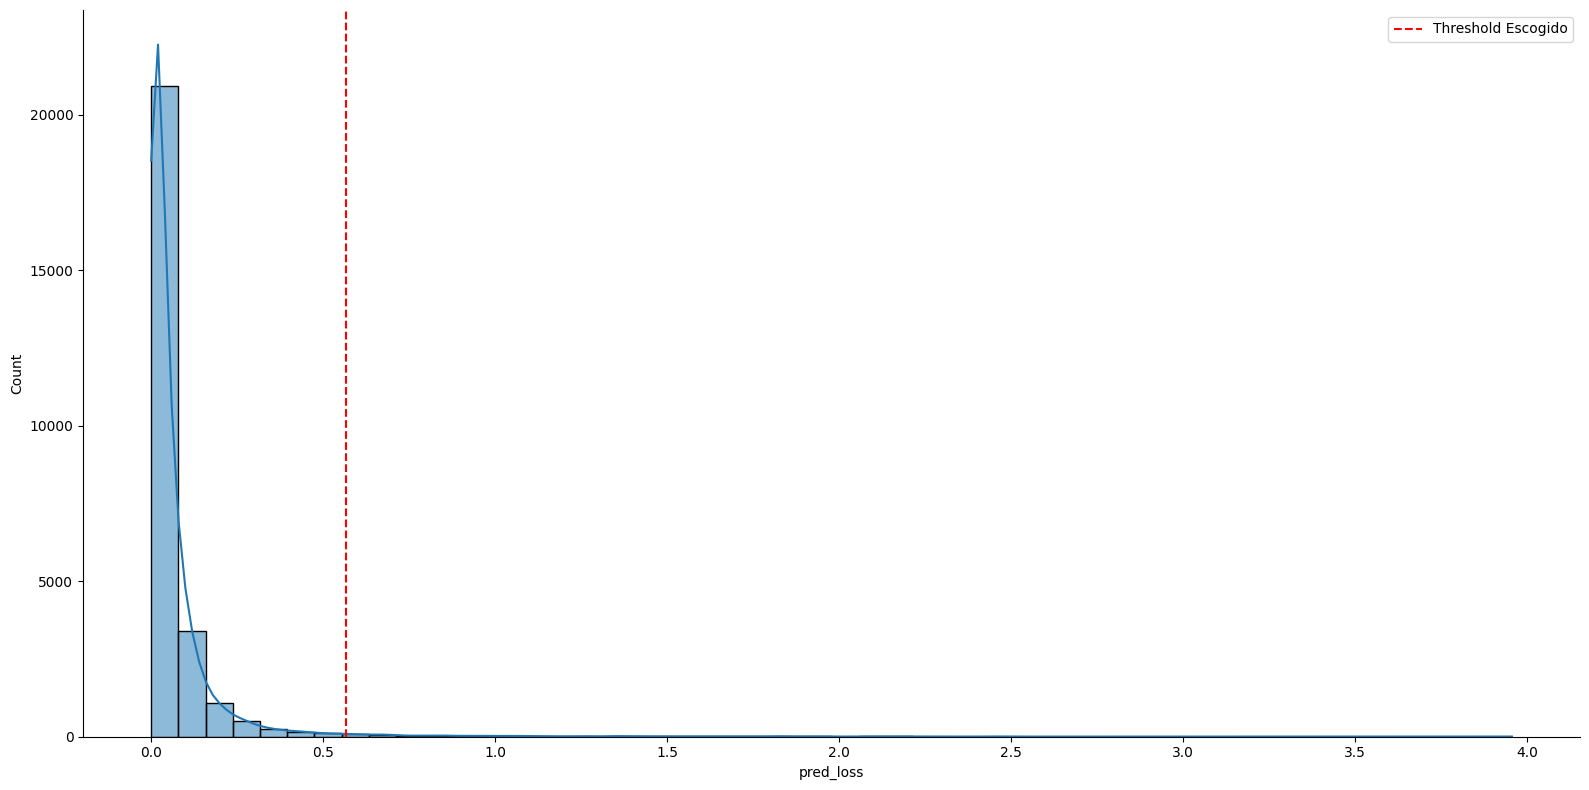

In [11]:
mu = train_preds.pred_loss.mean()
sd = train_preds.pred_loss.std()
sns.displot(x = "pred_loss", data = train_preds, bins = 50, kde = True, height = 8, aspect = 2)
plt.axvline(x = mu + 3*sd, color = "r", linestyle = "--", label = "Threshold Escogido")
plt.legend();

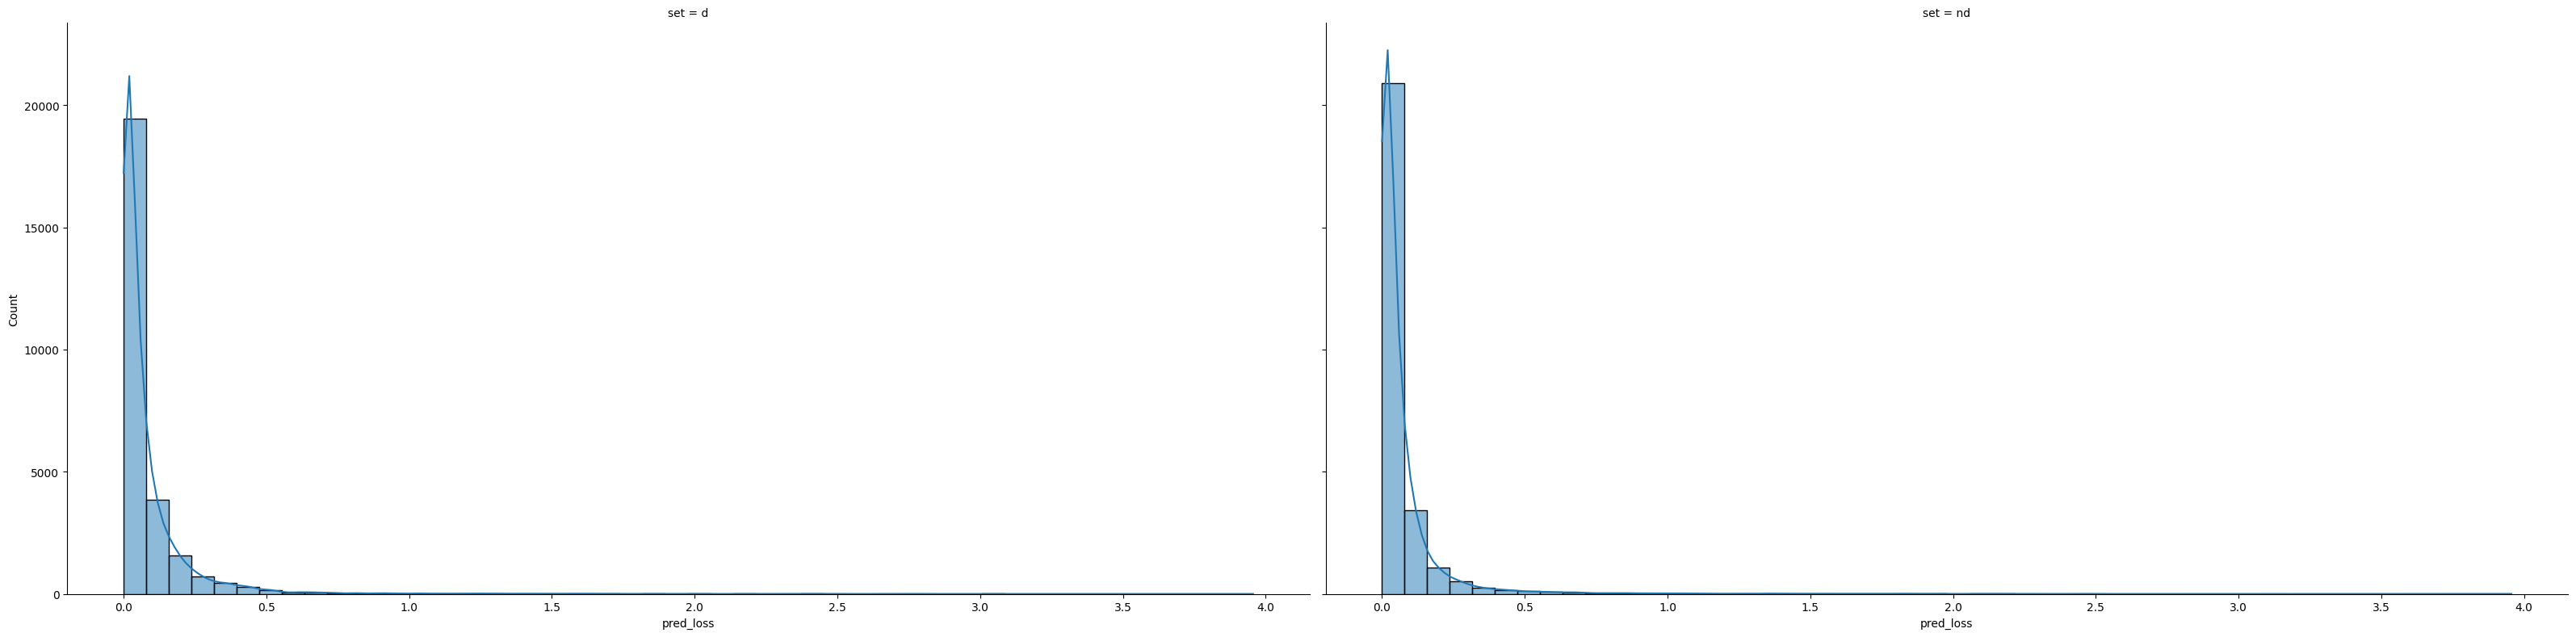

In [12]:
sns.displot(x = "pred_loss", data=preds, col = "set", bins = 50, kde = True, height = 8, aspect = 2);

# Sólo fitro de 2016

In [13]:
def metrics(results):
    tp = results.loc["d"]
    fp = results.loc["nd"]
    tn = 100-results.loc["nd"]
    fn = 100-results.loc["d"]
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp /( tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return accuracy, precision, recall, f1

In [14]:
results_m_3sd = preds.query(f"date >= '01-01-2016' and pred_loss >= {mu + 3*sd}").ts_id.drop_duplicates().str.split("_", expand=True)[1].value_counts()
metrics(results_m_3sd)

(0.645, 0.704225352112676, 0.5, 0.5847953216374269)

In [15]:
results_m_3sd

d     50
nd    21
Name: 1, dtype: int64

# Separación por clase



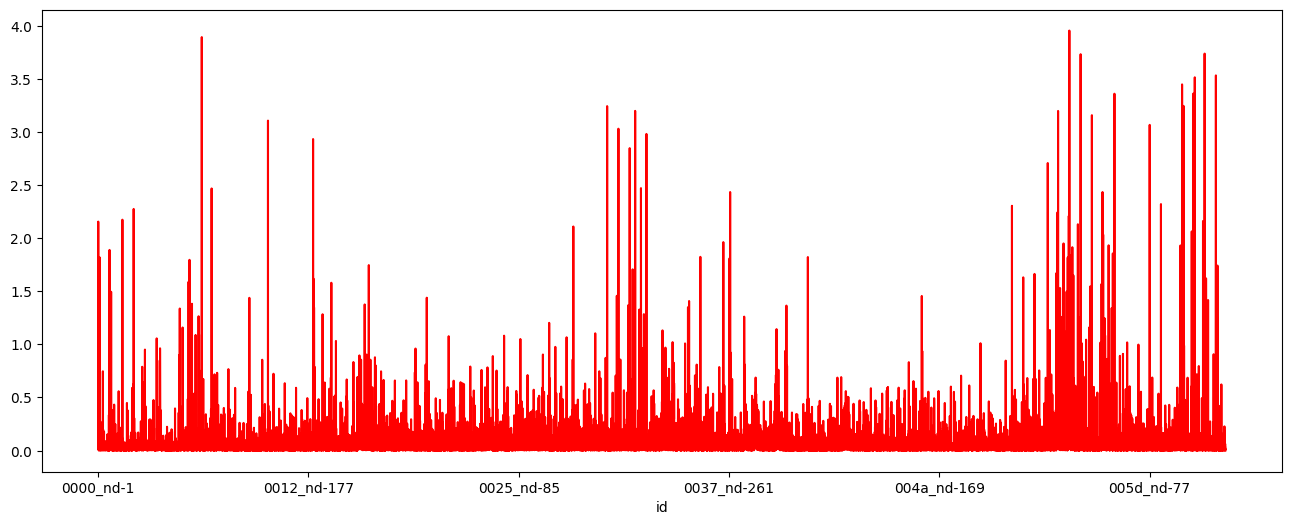

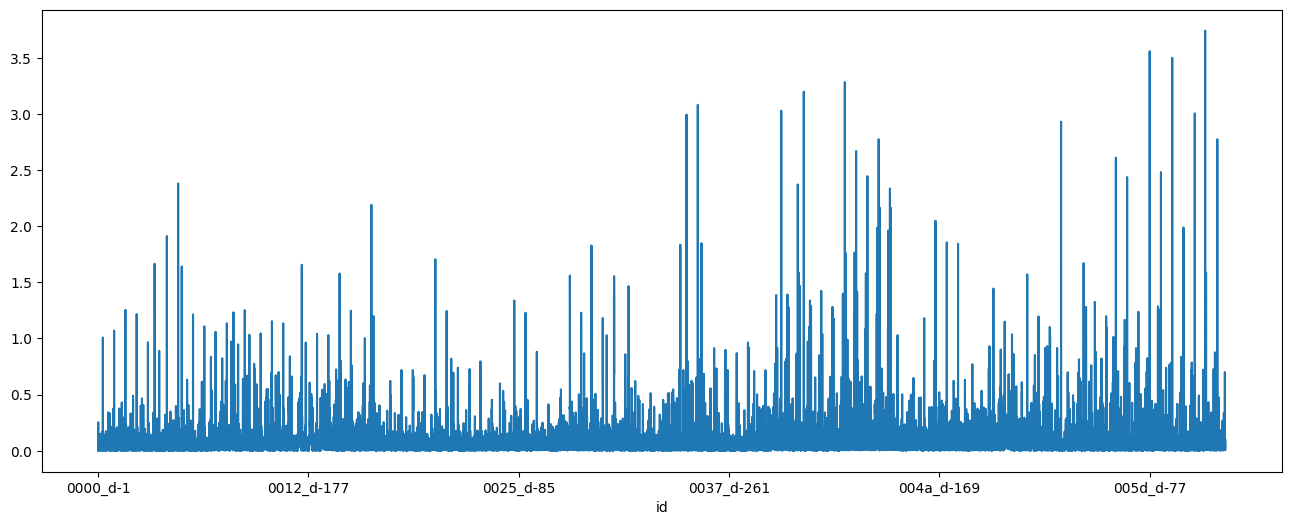

In [16]:
nd = preds.query('set == "nd"')
d = preds.query('set == "d"')

nd.set_index("id")["pred_loss"].plot(figsize=(16,6), color = "r")
plt.show()
d.set_index("id")["pred_loss"].plot(figsize=(16,6));

In [18]:
WINDOW = 10
preds["anomaly"] = np.where(preds.pred_loss > mu + 3*sd, 1, 0)
preds["cum_anomaly"] = preds.anomaly.rolling(WINDOW).sum().shift(-WINDOW).fillna(0)
preds

,date,ndvi,ts_id,ndvi_null,id,pred_loss,set,anomaly,cum_anomaly
0,2000-01-31,0.532071,0000_d,False,0000_d-1,0.000004,d,0,0.0
1,2000-02-29,0.444589,0000_d,False,0000_d-2,0.016152,d,0,0.0
2,2000-03-31,0.423470,0000_d,False,0000_d-3,0.031253,d,0,0.0
3,2000-04-30,0.352608,0000_d,False,0000_d-4,0.133738,d,0,0.0
4,2000-05-31,0.305406,0000_d,False,0000_d-5,0.252584,d,0,0.0
...,...,...,...,...,...,...,...,...,...
53595,2021-12-31,0.610939,0063_nd,False,0063_nd-264,0.002665,nd,0,0.0
53596,2022-01-31,0.566278,0063_nd,False,0063_nd-265,0.018239,nd,0,0.0
53597,2022-02-28,0.563392,0063_nd,False,0063_nd-266,0.012008,nd,0,0.0
53598,2022-03-31,0.547669,0063_nd,False,0063_nd-267,0.010095,nd,0,0.0


In [19]:
preds.query("anomaly == 1 and ndvi_null == True and date > '01-01-2016'")

,date,ndvi,ts_id,ndvi_null,id,pred_loss,set,anomaly,cum_anomaly
3181,2019-06-30,0.070106,000b_d,True,000b_d-234,0.663452,d,1,3.0
3183,2019-08-31,0.075515,000b_d,True,000b_d-236,0.623323,d,1,3.0


In [20]:
def plot_anomalies(ide):
    preds.query(f'ts_id == "{ide}"').set_index("date")[["ndvi"]].plot(figsize = (15,6))
    ides = preds.query(f"date >= '01-01-2016' and ts_id == '{ide}' and anomaly == 1").id.tolist()
    dates = preds.query("date >= '01-01-2016' and id in @ides").date.tolist()
    plt.vlines(x = dates, ymin = 0, ymax = 1, color = "red", alpha = 0.3)
    plt.xticks(rotation=90)
    plt.title(f"{ide}")
    plt.show()

In [22]:
ANOMALY_THRESHOLD = 2
findings = preds.query(f"date >= '01-01-2016' and cum_anomaly > {ANOMALY_THRESHOLD}").drop_duplicates(subset = "ts_id")
findings.set.value_counts()

d    9
Name: set, dtype: int64

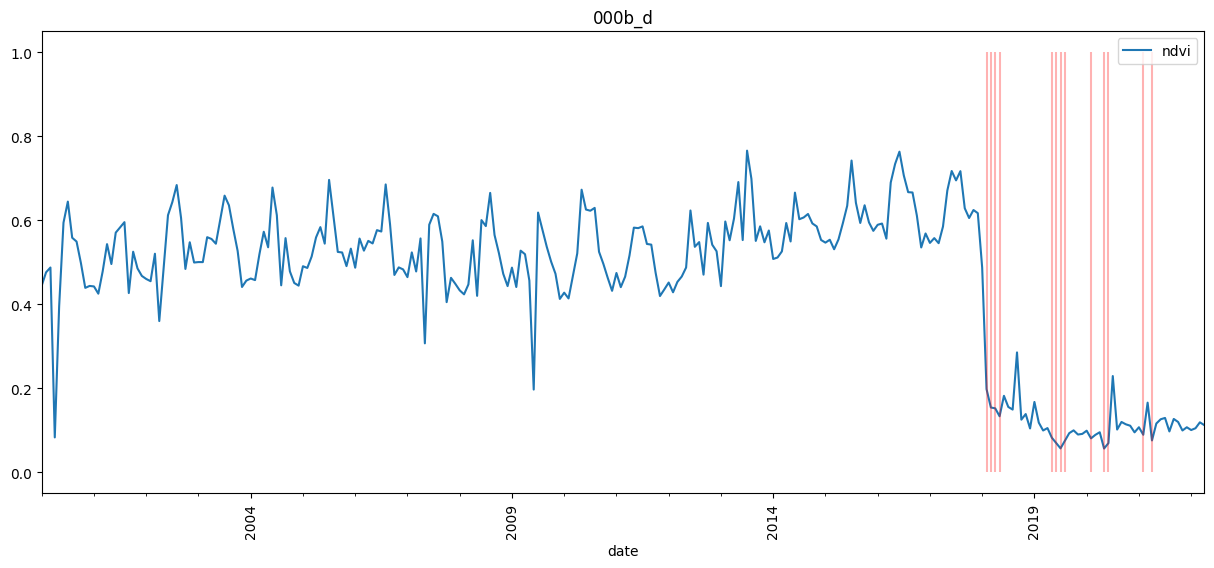

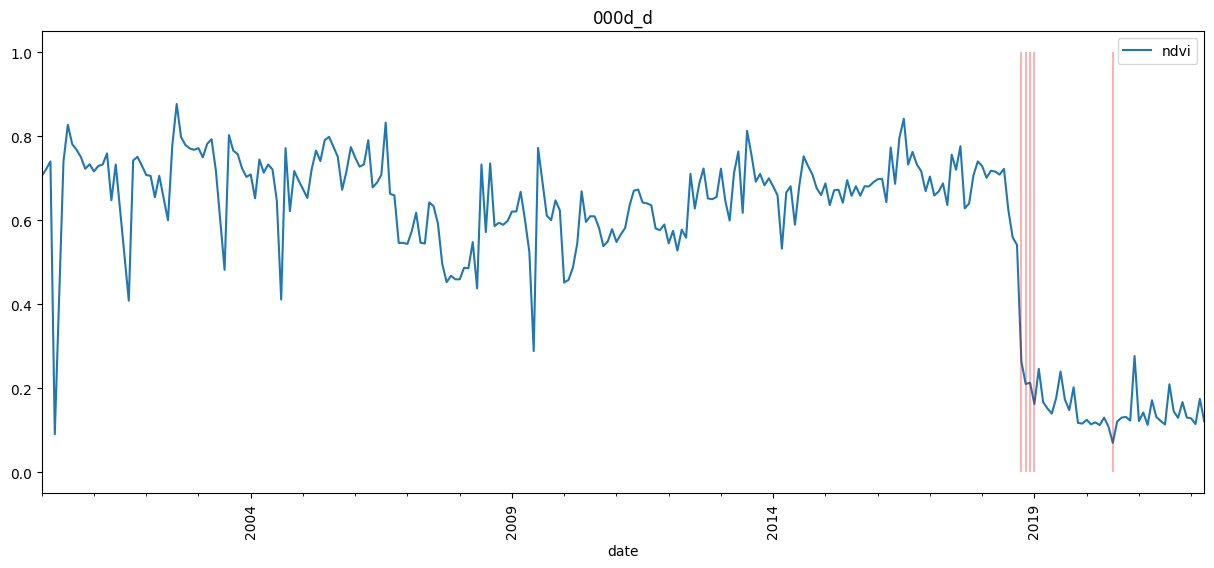

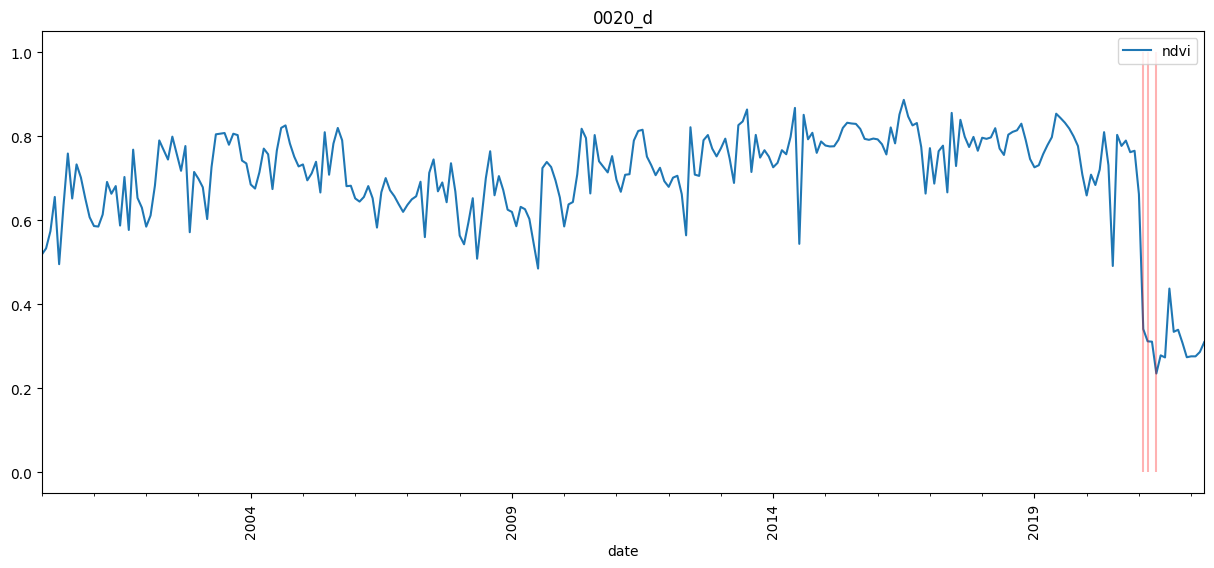

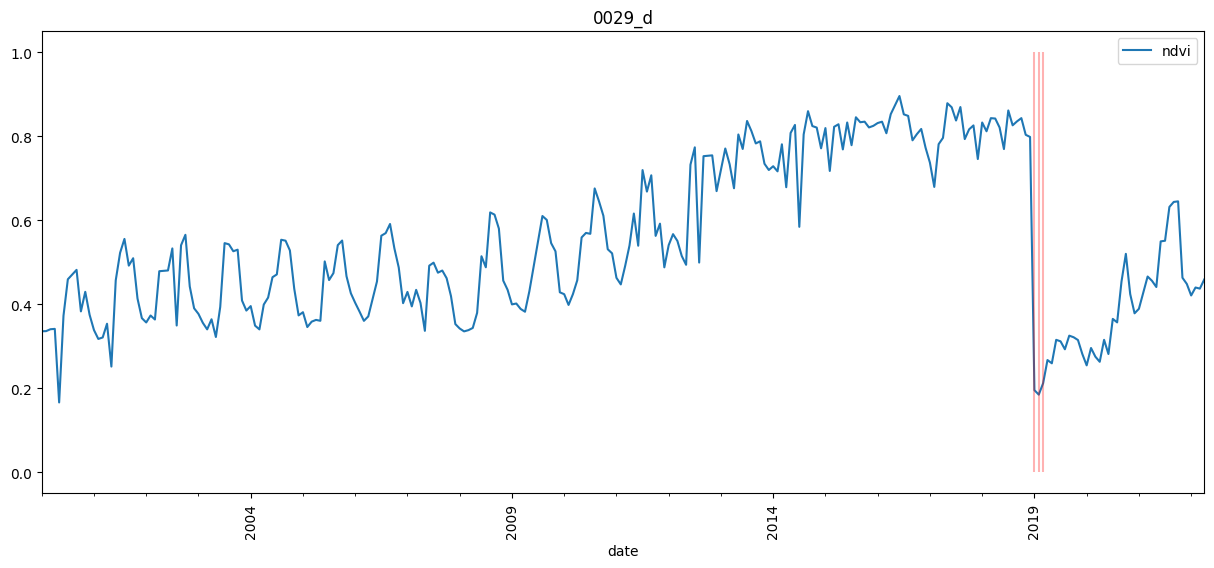

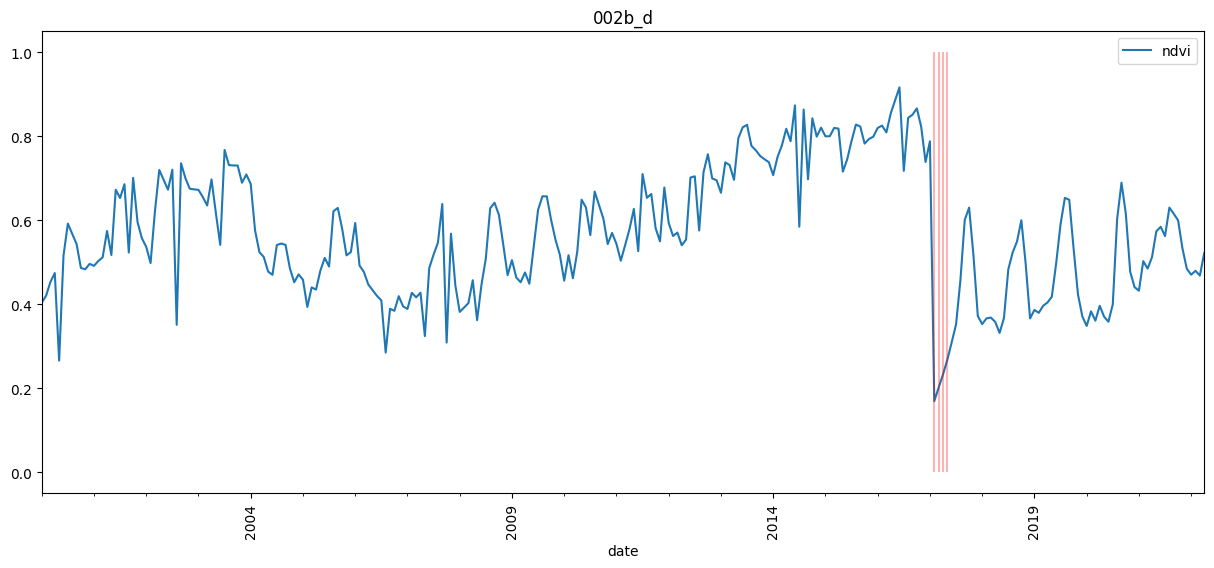

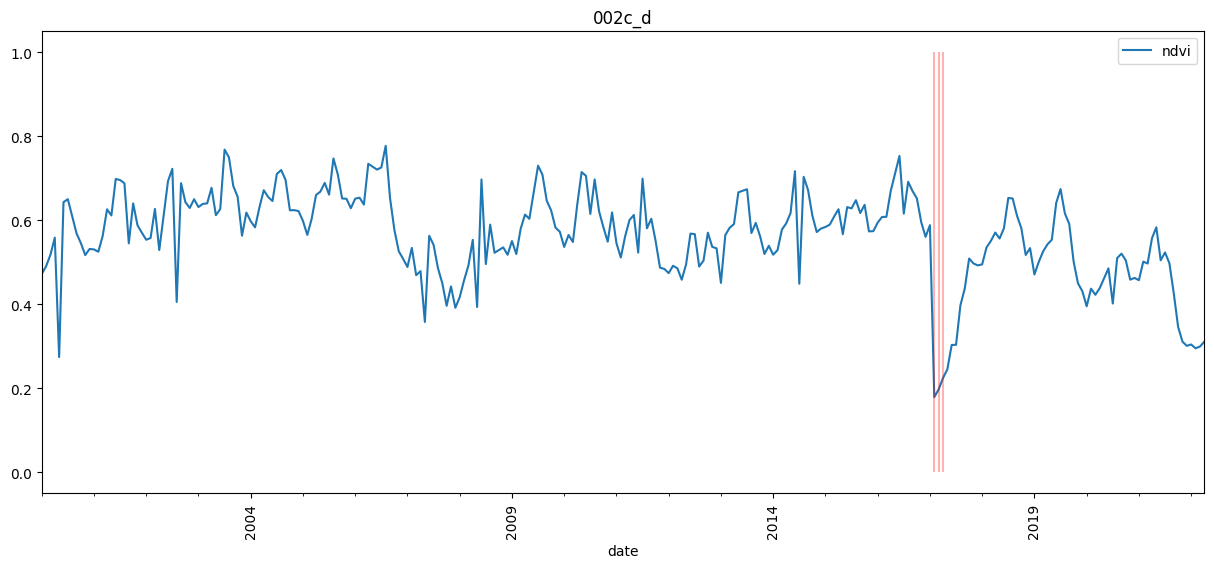

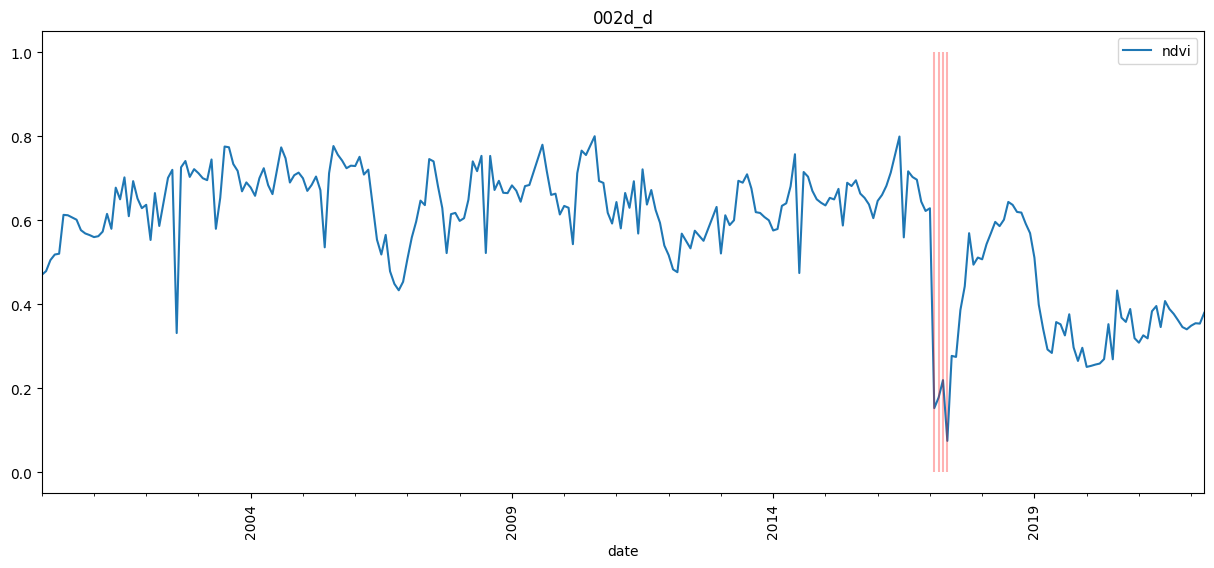

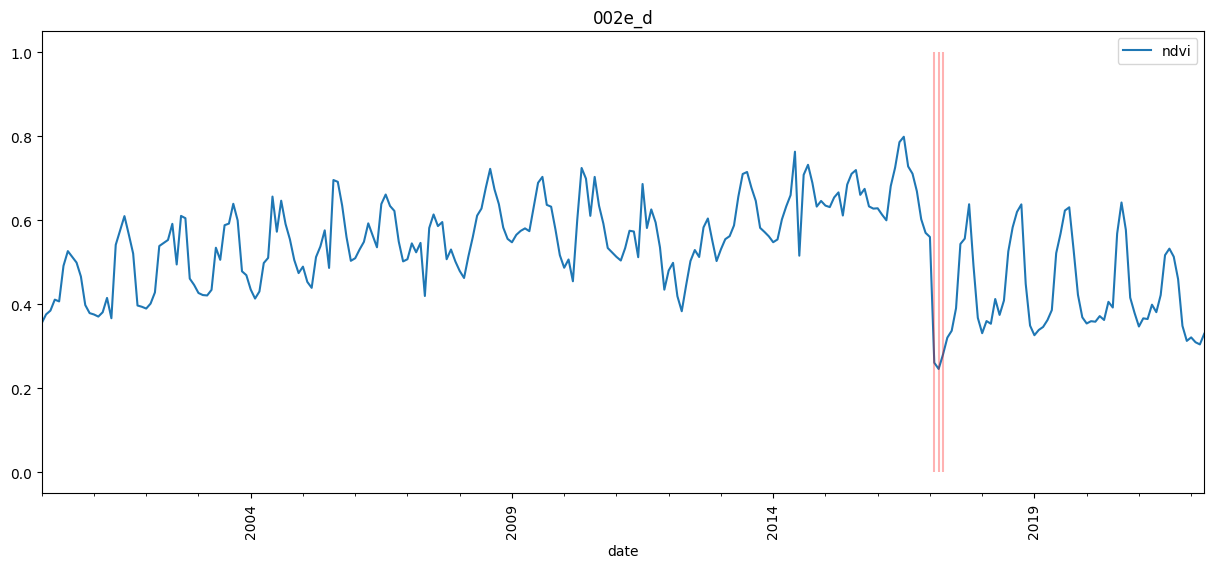

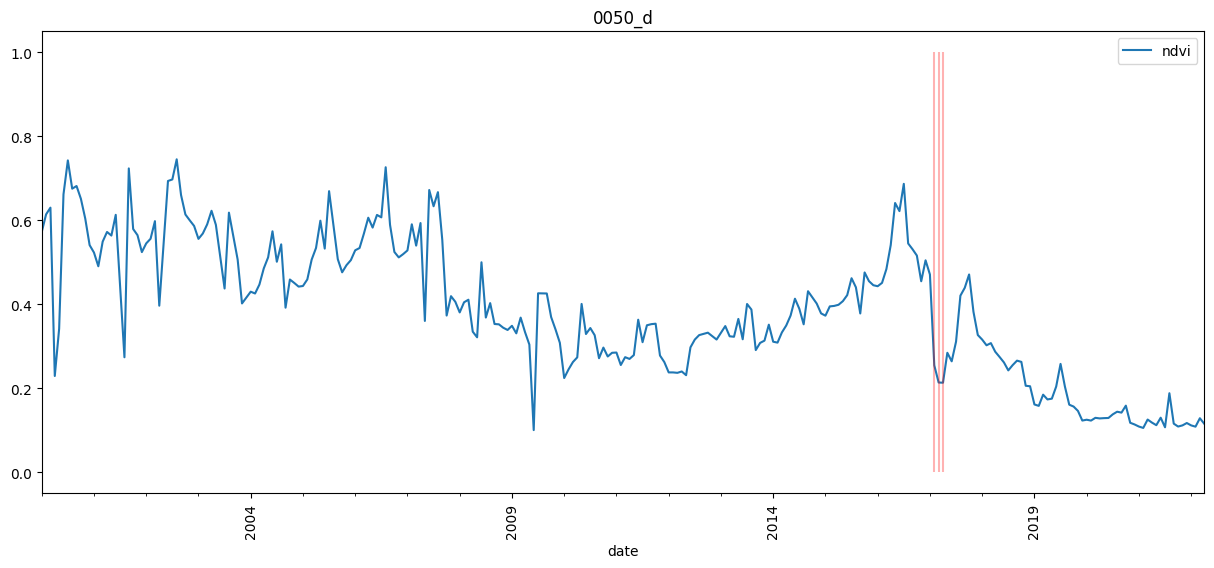

In [23]:
for ide in findings.ts_id.unique():
    plot_anomalies(ide)  